# Evaluating gender pay gap 


**Pay gap** or **wage disparity** is the average (or median) difference between the remuneration for men and women. It has been widely reported for years that women tend to be paid less than men. The extent of this gap varies across industries and countries see Blau & Kahn, 2016).

In this notebook, we illustrate full pay-gap analysis with the R code in this repository. We use a simulated data set to illustrate the analyses. We report the following:
* the median and average pay gaps across all roles
* the adjusted pay gap, using a linear regression with relevant HR-features as input variables
* the pay bands describing the distribution of men/women ratio across pay quartiles



In [11]:
# general options
options(repr.plot.width=10, repr.plot.height=8)
options(warn=-1)
# Uplaod required packages
library(ggplot2)
library(dplyr)
library(hrbrthemes)
library(reshape)


In [2]:
# import code
source('src/helpers.R')

### Fetching simulated data
To illustrate pay-gap analysis, we use a fictitious dataset simulated using Gaussian and Multinomial distributions.


In [3]:
# replace with your own path
pathdata<-"data/demodata.Rdata"
load(pathdata)
head(demodata)

,gender,regime,tenure,job,age,wage
,<fct>,<fct>,<dbl>,<fct>,<dbl>,<dbl>
1,woman,part-time,6.718378,general staff,61.25215,12.55120
2,woman,full-time,12.733815,general staff,43.06489,13.51619
3,woman,full-time,1.148053,general staff,60.02592,13.11457
4,woman,part-time,6.594874,general staff,31.52413,12.59266
5,woman,full-time,7.180504,general staff,63.70534,12.60708
6,woman,full-time,6.173719,general staff,38.31512,13.16587


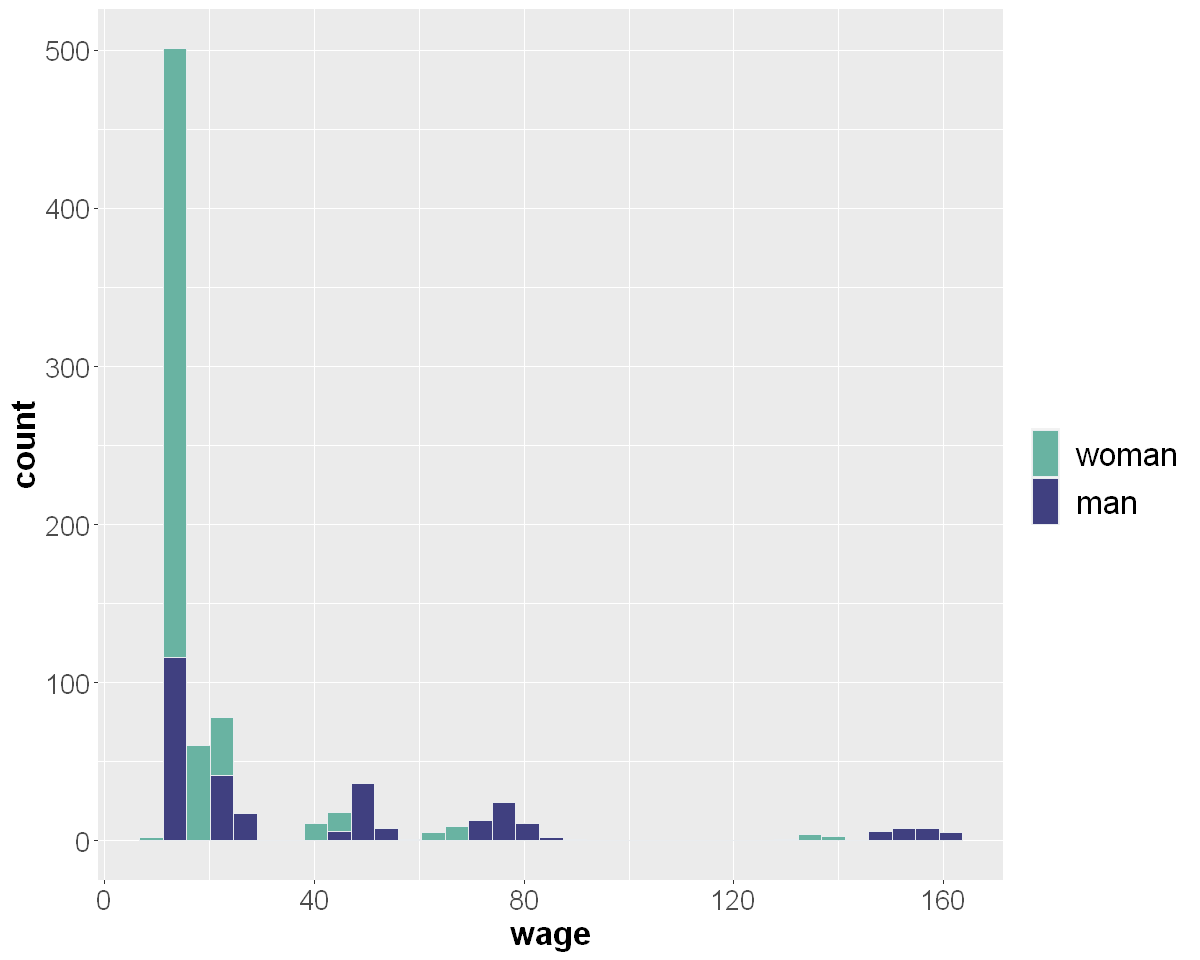

In [14]:
# display data
p <- ggplot(demodata, aes(x=wage, fill=gender)) +
    geom_histogram(color="#e9ecef", position = 'identity', bins=35) +
    scale_fill_manual(values=c("#69b3a2", "#404080")) +
    #theme_ipsum() +
    labs(fill="")+
    theme(legend.title = element_text(size = 20),legend.text = element_text( size = 20),axis.text.x = element_text(size=16),axis.text.y = element_text(size=16),
          axis.title=element_text(size=20,face="bold"))
print(p)

### Define groups of interest
Pay gap is usualy across different groups, corrsponding to different job types. Because the way groups are defined might be different than the way they are encoded in the data, we define the groups in a separate step.


In [5]:
# storestaff
pop_staff<-subset(demodata,job=='general staff')
# assistant manager
pop_amgr<-subset(demodata,job=='assistant manager')
#manager
pop_mgr<-subset(demodata,job=='manager')
#director
pop_director<-subset(demodata,job=='director')
# exec
pop_executive<-subset(demodata,job=='executive')

### Overview population
Exploring the data per group is a useful step to dteremine the relevance of the pay-gap figures that willbe calculated later. Typically, knowing the % of part timers per group helps determine wther it should be a fetaure in the adjusted pay-gap model.

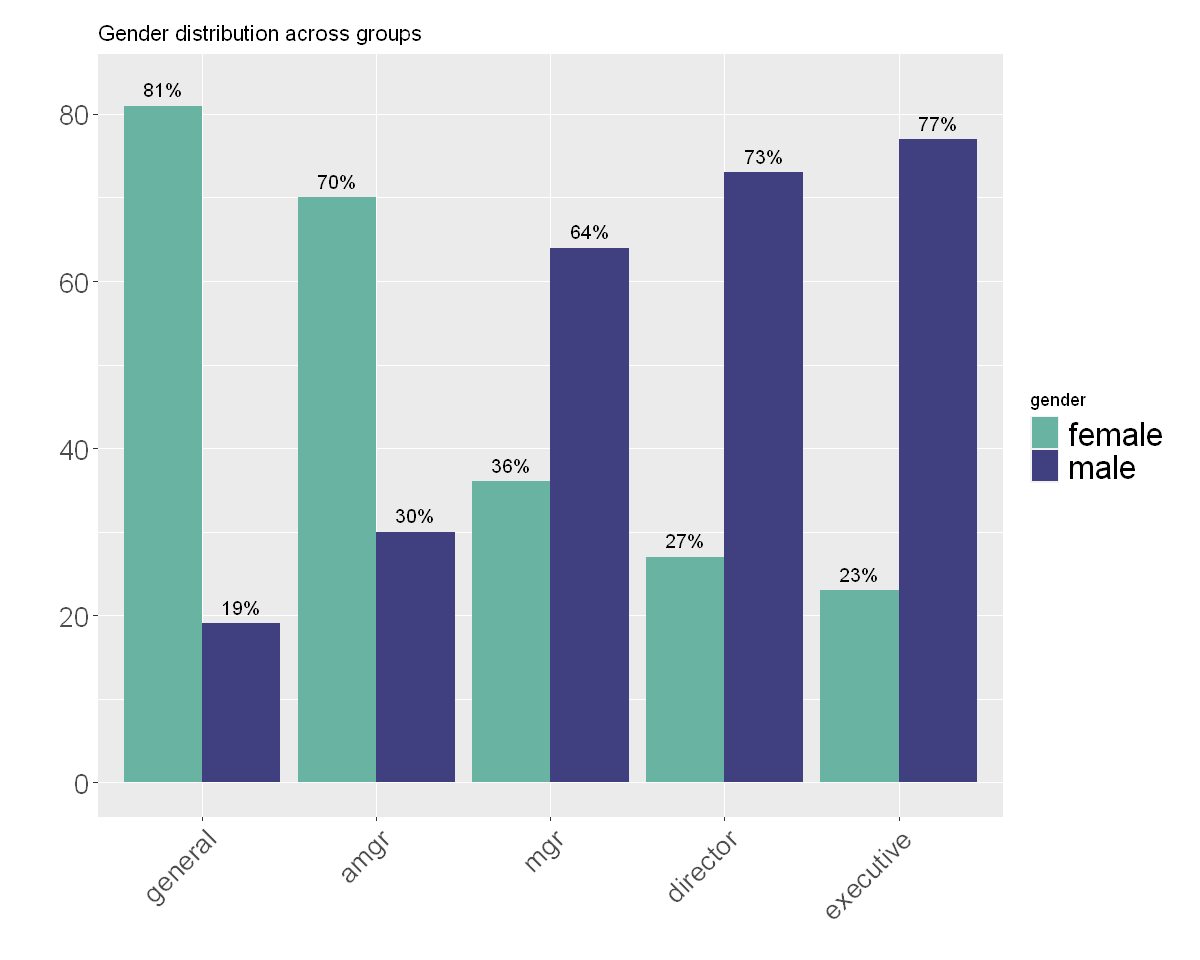

In [6]:
#---- population overview ------------------
overview_tab<-rbind.data.frame(popOverview(pop_staff,'general'),
                               popOverview(pop_amgr,'amgr'),
                               popOverview(pop_mgr,'mgr'),
                               popOverview(pop_director,'director'),
                               popOverview(pop_executive,'executive'))

# create a table formatted for ggplot2 unstacked barplots
overview_pl0<-overview_pl1<-overview_tab
overview_pl0$gender<-rep('female',nrow(overview_tab))
overview_pl1$gender<-rep('male',nrow(overview_tab))
overview_pl0$prop<-as.numeric(as.character(overview_pl0$`% Women`))
overview_pl1$prop<-abs(100-overview_pl0$prop)
overview_pl<-rbind.data.frame(overview_pl0,overview_pl1)           

# colors

# pdf('reporting/Dec_2019/figs/populations-1.pdf', height = 6, width = 9.5)
ggplot() +   
  geom_bar(data = overview_pl,aes(y = prop, x = Population,fill=gender), stat="identity", position = position_dodge(width = 0.9))+
  labs(y='',x='')+
  theme(axis.text.x = element_text(angle =45, hjust = 1, size=16),
        plot.margin = margin(0.5,0.5,0,0.5, "cm"), 
        legend.text = element_text( size = 20),
        axis.text.y = element_text(size=16),
        axis.title=element_text(size=20,face="bold"))+
        scale_fill_manual(values=c("#69b3a2", "#404080"))+
        geom_text(data=overview_pl, aes(x = Population,group=gender ,y = prop+2,label = paste0(signif(prop,2),"%")),
            color='black', size=4,
            position = position_dodge(0.9), size=3)+
        ggtitle('Gender distribution across groups')+
        NULL




### Unadjusted pay gap table

In [7]:
tab_unandjusted<-rbind.data.frame(unadjustedTab(pop_staff,'general'),
                                                   unadjustedTab(pop_amgr,'amgr'),
                                                   unadjustedTab(pop_mgr,'mgr'),
                                                   unadjustedTab(pop_director,'director'),
                                                   unadjustedTab(pop_executive,'executive'))

tab_unandjusted

Population,Size,Average gap %,Median gap %,%women
<fct>,<fct>,<dbl>,<dbl>,<fct>
general,619,8.57225,8.628712,81
amgr,196,13.68796,13.635775,70
mgr,80,12.27309,12.202417,36
director,70,11.35056,10.962926,27
executive,35,12.29093,11.689809,23


### Adjusted pay-gap
We next model the hourly wage with a linear model, which in turn will be used to compute the adjusted pay-gap.

The model is defined as: hourly wage ~ Gender (categorical) + Age + Tenure + Regime (categorical) 

In [8]:

#-----------------> adjusted figures for some pops 
#Not alll groups can be reported on due to the sample size and relevance
tab_adjusted=rbind.data.frame(
cbind('Population'='general staff','Size'=nrow(pop_staff),"Perc. women"=genderShare(pop_staff),reg_pop(pop_staff[,c('wage','tenure','gender')])),
cbind('Population'='assistant manager','Size'=nrow(pop_amgr),"Perc. women"=genderShare(pop_amgr),reg_pop(pop_amgr[,c('wage','tenure','gender')])),
cbind('Population'='manager','Size'=nrow(pop_mgr),"Perc. women"=genderShare(pop_mgr),reg_pop(pop_mgr[,c('wage','tenure','gender')])),
cbind('Population'='director','Size'=nrow(pop_director),"Perc. women"=genderShare(pop_director),reg_pop(pop_director[,c('wage','tenure','gender')])),
cbind('Population'='executive','Size'=nrow(pop_executive),"Perc. women"=genderShare(pop_executive),reg_pop(pop_executive[,c('wage','tenure','gender')])))

tab_adjusted$Size<-format(tab_adjusted$Size,big.mark = ',')
rownames(tab_adjusted)<-NULL
tab_adjusted



Population,Size,Perc. women,Unadjusted,Adjusted,R2
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<fct>
general staff,619,81,8.57225,8.62,42
assistant manager,196,70,13.68796,16.00,68
manager,80,36,12.27309,14.50,68
director,70,27,11.35056,13.80,60
executive,35,23,12.29093,11.10,81


### Plot pay-bands
We also compute the pay quartiles per gender, for each quartile, we compute the % of women vs men. These quartiles are typically reported in official reports. See here for an example  
[example](https://www.vodafone.com/content/dam/vodcom/sustainability/pdfs/uk-gender-pay-gap-report-2019.pdf)

Using such plots is essential to:
* determine the distributions of genders within each pay band 
* compare the results across brands and to other companies
* explain wage disparities without revealing the actual wage figures



Using Quartile as id variables

Using Quartile as id variables



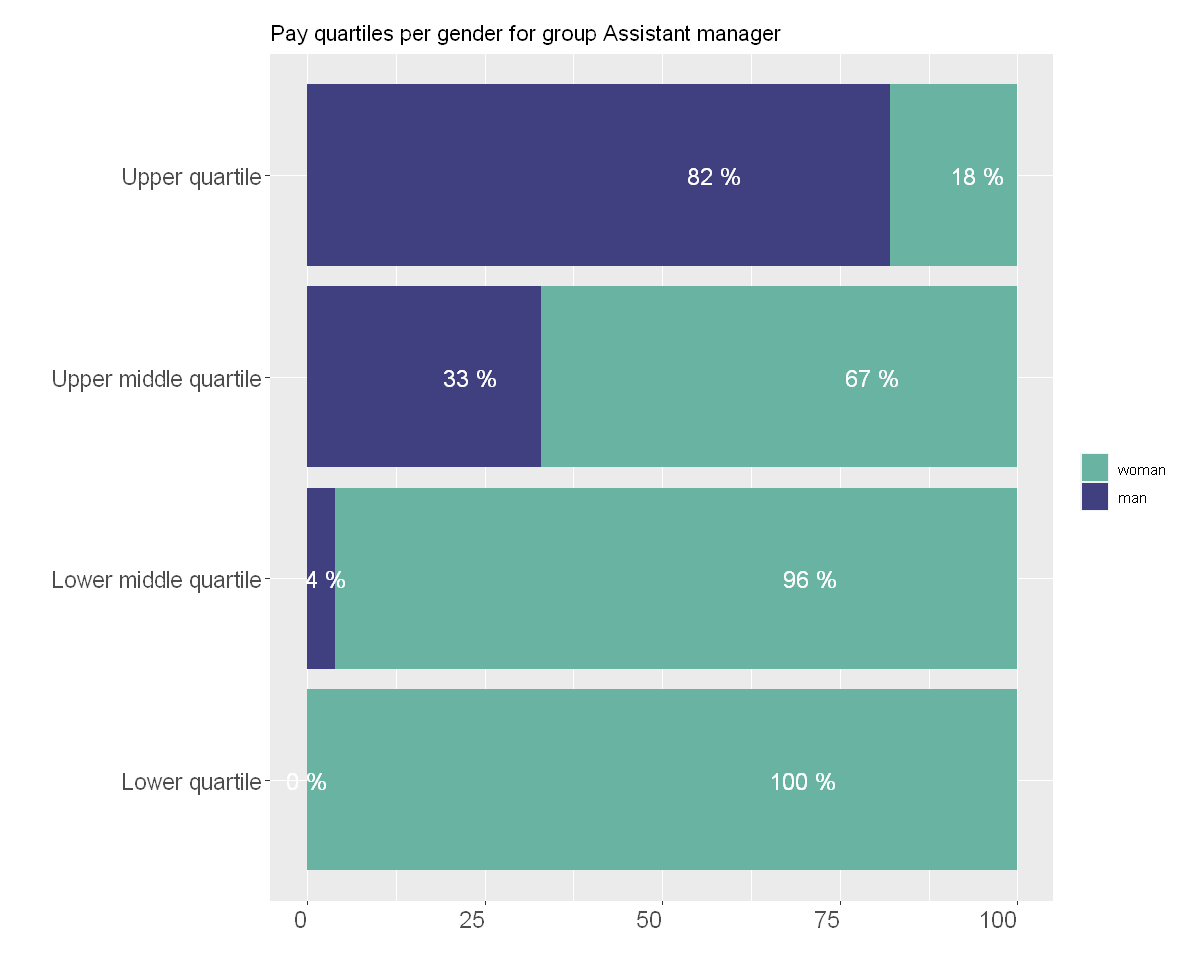

Using Quartile as id variables



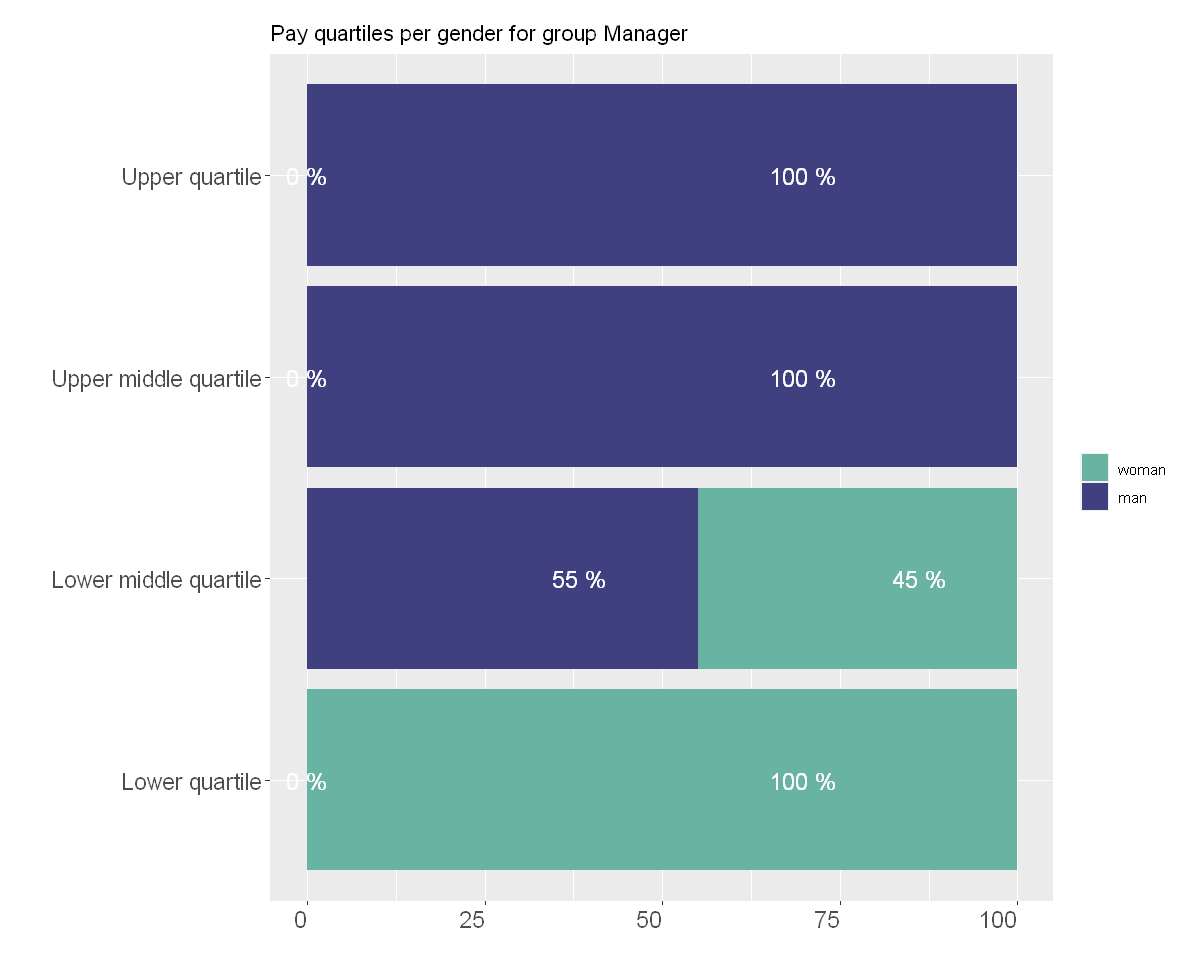

Using Quartile as id variables



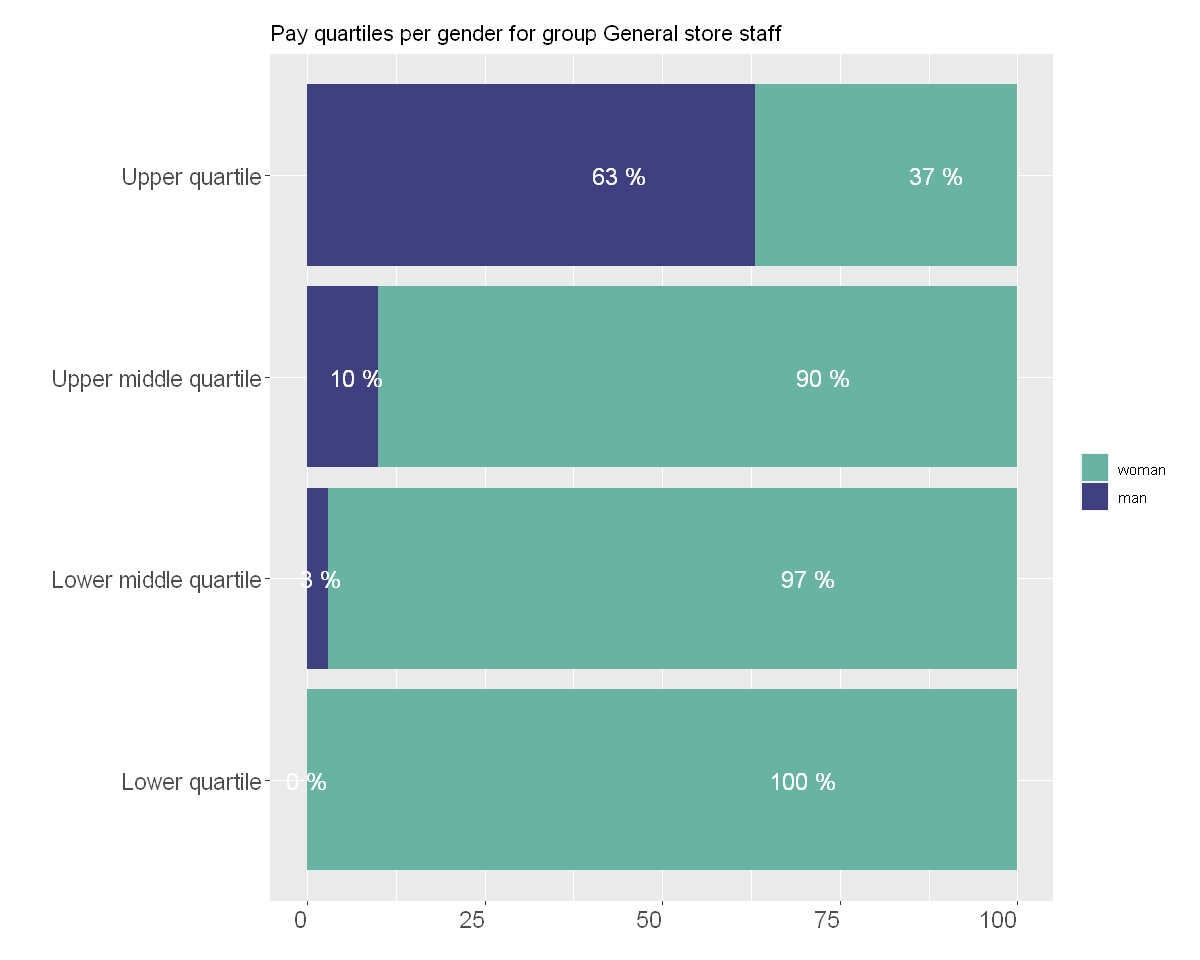

Using Quartile as id variables



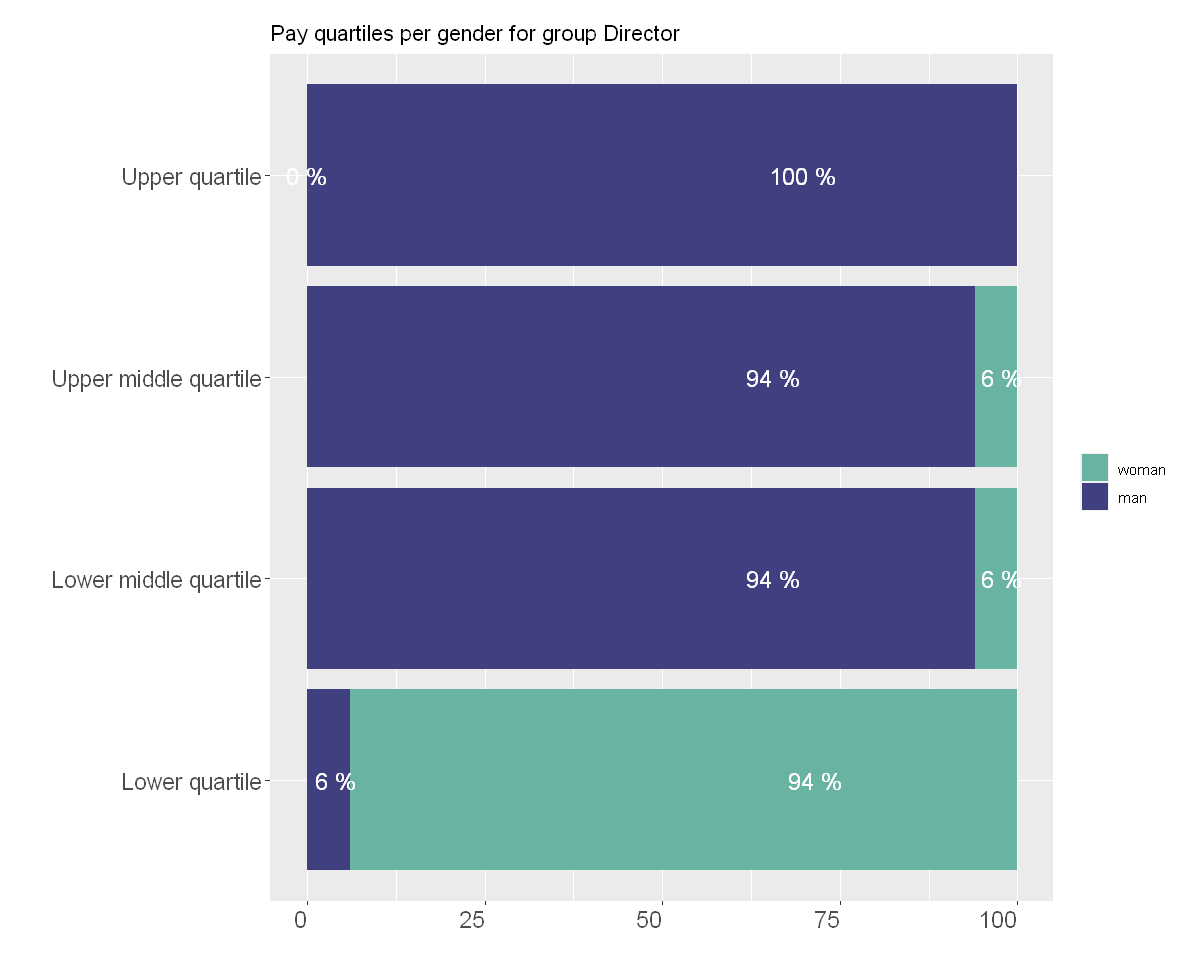

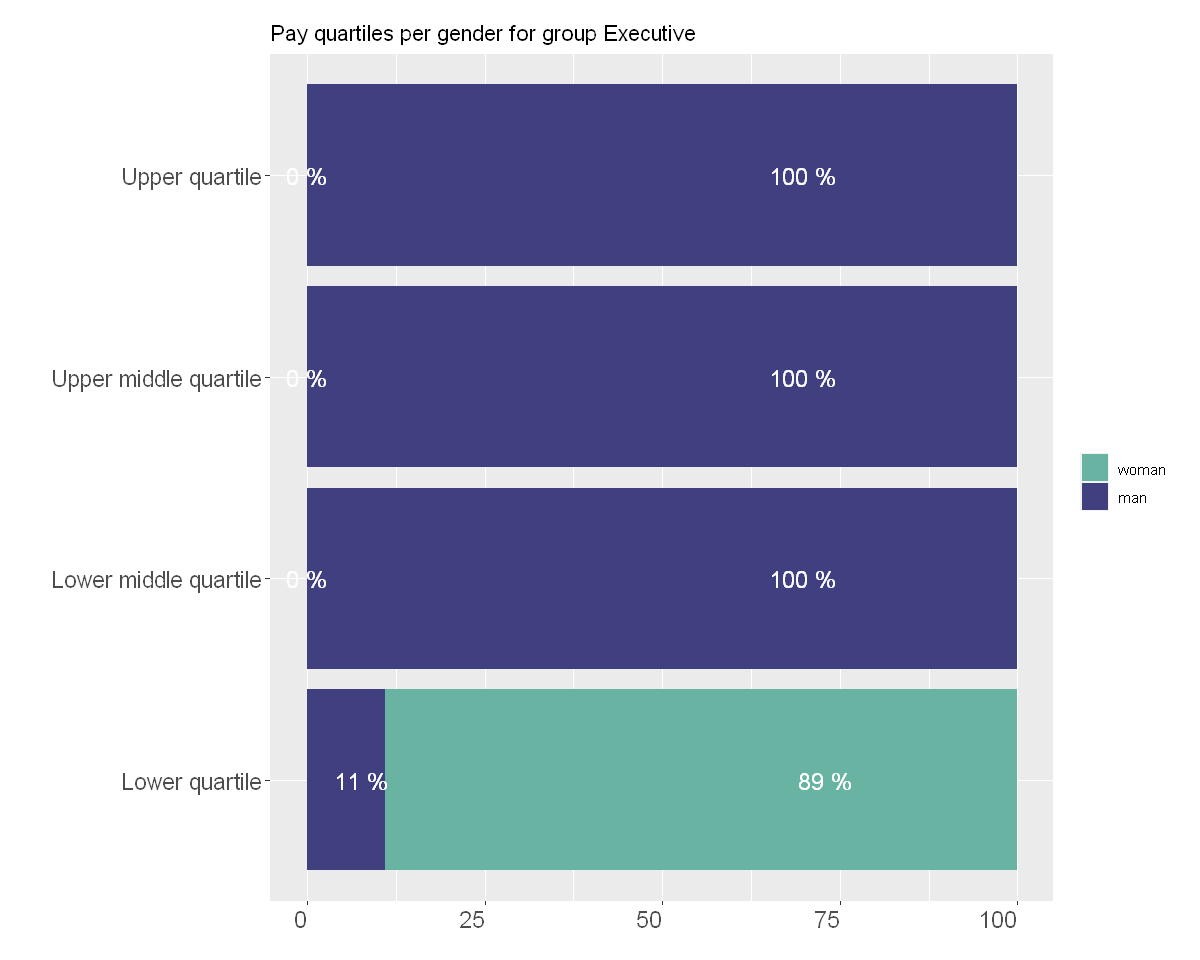

In [10]:

#4)---------------------Pay-Gap reporting --------------------------------------------#
source('src//helpers.R')
epsilon=0.02# error allowed in the group determination 0.25+epsilon
plotbands(tab = pop_amgr,nametab='Assistant manager',epsilon =epsilon)
plotbands(tab = pop_mgr, nametab='Manager', epsilon =epsilon)
plotbands(tab = pop_staff, nametab='General store staff', epsilon =epsilon)
plotbands(tab = pop_director, nametab='Director', epsilon =epsilon)
plotbands(tab = pop_executive,nametab='Executive', epsilon =epsilon)

### References
F.D. Blau & L.M. Kahn. The Gender Wage Gap: Extent, Trends and Explanations, Journal of economic literature, 2016.

[Example of a pay-gap report at Vodafone.](https://www.vodafone.com/content/dam/vodcom/sustainability/pdfs/uk-gender-pay-gap-report-2019.pdf)
